In [1]:
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,Reshape,Conv2DTranspose,BatchNormalization
from tensorflow.keras.layers import ReLU,Activation,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop

In [2]:
(S_train,_),(_,_) =  mnist.load_data()  # Input -> the images in the mnist dataset.

In [3]:
S_train.shape

(60000, 28, 28)

In [4]:
image_size = S_train.shape[1]

In [5]:
image_resize = image_size//4 

In [6]:
print(image_resize)

7


In [7]:
S_train = np.reshape(S_train,[-1,image_size,image_size,1]) # Converting the 2d tensor (28,28) into a 3d tensor (28,28,1)
S_train = S_train.astype('float32')/255  # Rescaling the images.

In [8]:
""" Hyperparamters, for the Architecture """
latent_dim = 100 #The dimension of the latent space.Generator network samples a vector from the latent space, dimension = 100.
batch_size = 64
iterations = 40000  # The number of iterations for training the network.
lr = 2e-4       # the learning rate.
decay = 6e-8  # decay rate -> RMS prop. Can you describe the algorithm?

In [9]:
""" Generator Network Parameters. """
kernel_size_gen = 5    # Size of the filters used (5,5,dim(n)), where n is the dimension of the depth axis.
layer_filters_gen = [128,64,32,1]    #  The number of filters used in the distinct convolutional(transposed) layers.

In [10]:
""" The Generator Network -> The Architecture - Dense Layer, 4 Transposed Convolutional Layers."""
""" The Generator Network tries to approximate the data generating distribution """
""" The Gen_Net maps the 100 dimensional latent space vector into  a 3d tensor of shape (28,28,1) 
Equivalently it maps the 100 latent space vector into a 784 dimensional vector """
input_ = Input(shape = (latent_dim,),name = "Gen_input") #Input layer, sampilng a 100 dimensional vector from the latent space.

S = Dense(image_resize*7*layer_filters_gen[0])(input_)  # A fully connected layer with weight tensor(2d) of shape (7*7*128,100),
                    # linear transformation, mapping the 100 dimensional vector into a 7*7*128 dimensional vector.

S = Reshape((7,image_resize,layer_filters_gen[0]))(S)  # Reshaping it into a 3d tensor of shape (7,7,128)

# Stacking 4 Transposed Convolutional layers, using a for loop.
# First two uses stride = 1, deconvolution, the latter two uses transposed convolution with stride = 2.
# BatchNormalization is applied before each layer to mitigate internal covariate shift.
for filters in layer_filters_gen:
    if filters > layer_filters_gen[-2]:
        strides = 2
    else:
        strides = 1
    S = BatchNormalization()(S)  # Applying batch normalization.
    S = ReLU()(S)                   # Relu activation applied componentwise.
    S = Conv2DTranspose(filters = filters, kernel_size = kernel_size_gen, strides = strides, padding = 'same')(S)
    
Output_Gen = Activation('sigmoid')(S)  # Applying the sigmoid function componentwise.

Output_Gen_shape = K.int_shape(Output_Gen)  # Storing the shape of the Output Tensor(3d tensor).

In [11]:
""" Instantiating the Generator Network """
Gen_Net = Model(input_,Output_Gen,name = "Gen_Network")

In [12]:
Gen_Net.summary()

Model: "Gen_Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       

In [13]:
""" Discriminator Network parameters """
kernel_size_dis = 5     # The size of the filters (5,5,dim(n)) n -> the dimension of the depth axis.
layer_filters_dis = [32,64,128,256]  # The number of weight filters used in the disparate Convolutional layers.

In [14]:
""" Discriminator Network-> A binary Classifier, outputs the probability of whether the datapoint belongs to the dataset or 
generated by the Generator Network."""
Dis_Input = Input(shape = (Output_Gen_shape[1],Output_Gen_shape[2],Output_Gen_shape[3])) # The Input layer of the discriminator.
                               # Takes in the 3d tensor, here image of shape (28,28,1).
S = Dis_Input

# Stack of 4 convolutional layer, the first three applies Convolution stride = 2, The last one uses stride = 1 convolution.

for filters in layer_filters_dis:
    if filters == layer_filters_dis[-1]:
        strides = 1
    else:
        strides = 2
    S = LeakyReLU(alpha = 0.2)(S)  # Lea
    S = Conv2D(filters = filters, kernel_size = kernel_size_dis, strides = strides, padding = 'same')((S))
S = Flatten()(S)
Output_dis = Dense(1,activation = 'sigmoid')(S)


In [15]:
""" Instantiating the Discriminator Network """
Dis_Net = Model(Dis_Input,Output_dis)

In [16]:
Dis_Net.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

In [17]:
Dis_Net.compile(optimizer =RMSprop(lr = lr,decay = decay),loss = 'binary_crossentropy')
# binary cross entropy -> the objective function.

In [18]:
# GANS -> Composing the two neural nets, composing the two totally differentiable vector fields, the discriminator Network 
# is a Scalar Field, Technically.
Dis_Net.trainable = False      # Freezing the weights of the discriminator network, while training the Generator Network.
Gan_input = Input(shape = (latent_dim,))
Gan_output =  Dis_Net(Gen_Net(Gan_input)).
Gan = Model(Gan_input,Gan_output)
Gan.compile(optimizer = RMSprop(lr = lr*0.5, decay = decay*0.5),loss = 'binary_crossentropy')
# Here binary_crossentropy is used as the loss/objective function.

In [19]:
Gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
Gen_Network (Functional)     (None, 28, 28, 1)         1301505   
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [23]:
Dir_fn = "S:\S_ML\DC_Gan_mnist\Gan_Function"
Dir_weights = "S:\S_ML\DC_Gan_mnist\Gan_images"

In [33]:
""" Gans Training.
 Train the Discriminator and the Generator Alternatively, given an iteration. I have trained the network for 40,000 iterations.
"""

train_size = S_train.shape[0]
for i in range(iterations):
     # Training the Discriminator Net which is a binary classifier
    # 1 batch of datapoints from the dataset (label = 1.0) and   generated_images by the generator network, given the iteration 
                                                                                #(label = 0.0).
    # randomly pick datapoints from the dataset.
    rand_ = np.random.randint(0,train_size,size = batch_size)
    real_images = S_train[rand_]
    
    
    # Sampling from the latent space-uniformly distributed vectors(100 dimensional vectors).
    latent_vec = np.random.uniform(-1.0,1.0,size = [batch_size,latent_dim])
    
    # generate images using the Generator Network given the iteration.
    generated_images = Gen_Net.predict(latent_vec)
    
    # real images(datapoints from the dataset)+ generated images(by the generator network), concatenating them for training the
    # discriminator network
    S = np.concatenate([real_images,generated_images])
        
    # label real and generated images.
    # real images are mapped to 1.
    # generated images are mapped to 0.
    y = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
    
    
    # training the discriminator network. 
    d_loss = Dis_Net.train_on_batch(S,y)
    
    
    
    # train the Generator network for 1  batch.
    # 1 batch of generated images with label = 1.0
    # since the discriminator weights are frozen in the Gan(the composite Network),
    # Only the generator is trained, ie  the weights of the generated network is updated while training.
    
    # sampling randomly uniform distribution(from the latent space).
    latent_vec = np.random.uniform(-1.0,1.0,size = [batch_size,latent_dim])
    
    # map generated images to 1.0, To train the Generator Network.
    
    y = np.ones([batch_size,1])
    
    # train the Generator network.
    
    g_loss = Gan.train_on_batch(latent_vec,y)
    

                                         
    if i % 10 == 0: # Every 10 th iteration, the following computations are performed.
        Gan.save_weights('Gan.h5')  
        
        Gen_Net.save_weights('Gen_Net.h5')
        print('discriminator loss at Time(%s) = %s'% (i,d_loss))
        print('adversarial loss at Time(%s) = %s'% (i,g_loss))
        
        img = image.array_to_img(generated_images[0]*255., scale = False)
        img.save(os.path.join(Dir_weights,'generated_image(MNISt)' + str(i) + '.png'))
        img = image.array_to_img(real_images[0]*255., scale = False)
        img.save(os.path.join(Dir_weights,'image_from_dataset(MNIST)' + str(i) + '.png'))


discriminator loss at Time(0) = 4.3055526475654915e-05
adversarial loss at Time(0) = 0.0006250834558159113
discriminator loss at Time(10) = 3.136428858852014e-05
adversarial loss at Time(10) = 0.0005153189413249493
discriminator loss at Time(20) = 0.0022228825837373734
adversarial loss at Time(20) = 0.2824620008468628
discriminator loss at Time(30) = 0.0005146441399119794
adversarial loss at Time(30) = 0.03517525643110275
discriminator loss at Time(40) = 0.0003871459630317986
adversarial loss at Time(40) = 0.009468505159020424
discriminator loss at Time(50) = 0.0003183853696100414
adversarial loss at Time(50) = 0.0036649140529334545
discriminator loss at Time(60) = 0.00015234455349855125
adversarial loss at Time(60) = 0.0022057094611227512
discriminator loss at Time(70) = 0.00030684942612424493
adversarial loss at Time(70) = 0.001639087568037212
discriminator loss at Time(80) = 0.00016804022016003728
adversarial loss at Time(80) = 0.00217339675873518
discriminator loss at Time(90) = 0.

discriminator loss at Time(780) = 0.5608891844749451
adversarial loss at Time(780) = 1.1469056606292725
discriminator loss at Time(790) = 0.5673257112503052
adversarial loss at Time(790) = 0.9284929633140564
discriminator loss at Time(800) = 0.5372244715690613
adversarial loss at Time(800) = 0.7210288643836975
discriminator loss at Time(810) = 0.5714015364646912
adversarial loss at Time(810) = 0.5907613635063171
discriminator loss at Time(820) = 0.48044097423553467
adversarial loss at Time(820) = 0.9562779068946838
discriminator loss at Time(830) = 0.5624286532402039
adversarial loss at Time(830) = 0.6639605760574341
discriminator loss at Time(840) = 0.5569204092025757
adversarial loss at Time(840) = 0.6624164581298828
discriminator loss at Time(850) = 0.5250289440155029
adversarial loss at Time(850) = 1.3045244216918945
discriminator loss at Time(860) = 0.5663799047470093
adversarial loss at Time(860) = 1.2786308526992798
discriminator loss at Time(870) = 0.5131930112838745
adversaria

discriminator loss at Time(1560) = 0.5512980222702026
adversarial loss at Time(1560) = 1.1039366722106934
discriminator loss at Time(1570) = 0.4500119090080261
adversarial loss at Time(1570) = 0.9609850645065308
discriminator loss at Time(1580) = 0.5978707671165466
adversarial loss at Time(1580) = 1.2475192546844482
discriminator loss at Time(1590) = 0.5872520208358765
adversarial loss at Time(1590) = 1.2115437984466553
discriminator loss at Time(1600) = 0.5139471292495728
adversarial loss at Time(1600) = 1.4778590202331543
discriminator loss at Time(1610) = 0.46981126070022583
adversarial loss at Time(1610) = 1.3293898105621338
discriminator loss at Time(1620) = 0.6553046107292175
adversarial loss at Time(1620) = 1.8900301456451416
discriminator loss at Time(1630) = 0.6066467761993408
adversarial loss at Time(1630) = 0.9264984130859375
discriminator loss at Time(1640) = 0.5591405034065247
adversarial loss at Time(1640) = 0.8726954460144043
discriminator loss at Time(1650) = 0.48730960

discriminator loss at Time(2340) = 0.4779317378997803
adversarial loss at Time(2340) = 1.7251405715942383
discriminator loss at Time(2350) = 0.5884180068969727
adversarial loss at Time(2350) = 1.3948416709899902
discriminator loss at Time(2360) = 0.4892263412475586
adversarial loss at Time(2360) = 1.0832080841064453
discriminator loss at Time(2370) = 0.5006685853004456
adversarial loss at Time(2370) = 1.5860096216201782
discriminator loss at Time(2380) = 0.5272188782691956
adversarial loss at Time(2380) = 1.2252748012542725
discriminator loss at Time(2390) = 0.5340198874473572
adversarial loss at Time(2390) = 0.7422901391983032
discriminator loss at Time(2400) = 0.471026211977005
adversarial loss at Time(2400) = 1.191046118736267
discriminator loss at Time(2410) = 0.49204516410827637
adversarial loss at Time(2410) = 1.510353446006775
discriminator loss at Time(2420) = 0.5411713719367981
adversarial loss at Time(2420) = 0.7596738338470459
discriminator loss at Time(2430) = 0.46240717172

discriminator loss at Time(3120) = 0.507869303226471
adversarial loss at Time(3120) = 1.912102222442627
discriminator loss at Time(3130) = 0.5213659405708313
adversarial loss at Time(3130) = 0.8705472946166992
discriminator loss at Time(3140) = 0.489153653383255
adversarial loss at Time(3140) = 1.4490667581558228
discriminator loss at Time(3150) = 0.4436976909637451
adversarial loss at Time(3150) = 1.2354769706726074
discriminator loss at Time(3160) = 0.4401923418045044
adversarial loss at Time(3160) = 1.008865237236023
discriminator loss at Time(3170) = 0.48556774854660034
adversarial loss at Time(3170) = 1.5873647928237915
discriminator loss at Time(3180) = 0.5244954824447632
adversarial loss at Time(3180) = 2.0277061462402344
discriminator loss at Time(3190) = 0.5114461183547974
adversarial loss at Time(3190) = 1.1649420261383057
discriminator loss at Time(3200) = 0.49267223477363586
adversarial loss at Time(3200) = 1.712971806526184
discriminator loss at Time(3210) = 0.423847615718

discriminator loss at Time(3900) = 0.5307121276855469
adversarial loss at Time(3900) = 1.4928345680236816
discriminator loss at Time(3910) = 0.4637799859046936
adversarial loss at Time(3910) = 1.2247869968414307
discriminator loss at Time(3920) = 0.4726852774620056
adversarial loss at Time(3920) = 1.657160758972168
discriminator loss at Time(3930) = 0.4857464134693146
adversarial loss at Time(3930) = 1.0535283088684082
discriminator loss at Time(3940) = 0.5638442039489746
adversarial loss at Time(3940) = 1.5202213525772095
discriminator loss at Time(3950) = 0.5131652355194092
adversarial loss at Time(3950) = 1.3306703567504883
discriminator loss at Time(3960) = 0.4667350947856903
adversarial loss at Time(3960) = 1.702054738998413
discriminator loss at Time(3970) = 0.4866918921470642
adversarial loss at Time(3970) = 1.3967511653900146
discriminator loss at Time(3980) = 0.5609225630760193
adversarial loss at Time(3980) = 1.1321725845336914
discriminator loss at Time(3990) = 0.49291822314

discriminator loss at Time(4680) = 0.5028772354125977
adversarial loss at Time(4680) = 1.2066675424575806
discriminator loss at Time(4690) = 0.6785252094268799
adversarial loss at Time(4690) = 1.6634504795074463
discriminator loss at Time(4700) = 0.5061124563217163
adversarial loss at Time(4700) = 1.3416728973388672
discriminator loss at Time(4710) = 0.5432240962982178
adversarial loss at Time(4710) = 1.8229540586471558
discriminator loss at Time(4720) = 0.5219146013259888
adversarial loss at Time(4720) = 1.1206753253936768
discriminator loss at Time(4730) = 0.5470340251922607
adversarial loss at Time(4730) = 1.6872849464416504
discriminator loss at Time(4740) = 0.5800930261611938
adversarial loss at Time(4740) = 0.996087372303009
discriminator loss at Time(4750) = 0.49103474617004395
adversarial loss at Time(4750) = 1.57264244556427
discriminator loss at Time(4760) = 0.5115941762924194
adversarial loss at Time(4760) = 1.27370023727417
discriminator loss at Time(4770) = 0.4960337579250

discriminator loss at Time(5460) = 0.5842013359069824
adversarial loss at Time(5460) = 1.3477004766464233
discriminator loss at Time(5470) = 0.4660825729370117
adversarial loss at Time(5470) = 1.6141672134399414
discriminator loss at Time(5480) = 0.5140747427940369
adversarial loss at Time(5480) = 1.0257422924041748
discriminator loss at Time(5490) = 0.4557954967021942
adversarial loss at Time(5490) = 1.286888837814331
discriminator loss at Time(5500) = 0.607604444026947
adversarial loss at Time(5500) = 0.9402320981025696
discriminator loss at Time(5510) = 0.5037680864334106
adversarial loss at Time(5510) = 1.3447496891021729
discriminator loss at Time(5520) = 0.5488919615745544
adversarial loss at Time(5520) = 0.9163573980331421
discriminator loss at Time(5530) = 0.5525178909301758
adversarial loss at Time(5530) = 1.4501937627792358
discriminator loss at Time(5540) = 0.5456046462059021
adversarial loss at Time(5540) = 1.2436072826385498
discriminator loss at Time(5550) = 0.54745280742

discriminator loss at Time(6240) = 0.5948055982589722
adversarial loss at Time(6240) = 1.1246449947357178
discriminator loss at Time(6250) = 0.5884335041046143
adversarial loss at Time(6250) = 1.3618087768554688
discriminator loss at Time(6260) = 0.5639979839324951
adversarial loss at Time(6260) = 1.5114580392837524
discriminator loss at Time(6270) = 0.5140284299850464
adversarial loss at Time(6270) = 1.278066635131836
discriminator loss at Time(6280) = 0.6367459297180176
adversarial loss at Time(6280) = 1.5552215576171875
discriminator loss at Time(6290) = 0.5281946659088135
adversarial loss at Time(6290) = 1.0321195125579834
discriminator loss at Time(6300) = 0.5303806066513062
adversarial loss at Time(6300) = 1.5711387395858765
discriminator loss at Time(6310) = 0.5549132227897644
adversarial loss at Time(6310) = 1.0811175107955933
discriminator loss at Time(6320) = 0.6123121976852417
adversarial loss at Time(6320) = 1.7724863290786743
discriminator loss at Time(6330) = 0.5135537385

discriminator loss at Time(7020) = 0.48112720251083374
adversarial loss at Time(7020) = 1.2546403408050537
discriminator loss at Time(7030) = 0.5490554571151733
adversarial loss at Time(7030) = 1.4999796152114868
discriminator loss at Time(7040) = 0.5321150422096252
adversarial loss at Time(7040) = 0.9884631037712097
discriminator loss at Time(7050) = 0.5763635635375977
adversarial loss at Time(7050) = 0.9835072755813599
discriminator loss at Time(7060) = 0.5608543753623962
adversarial loss at Time(7060) = 1.1438820362091064
discriminator loss at Time(7070) = 0.5803359746932983
adversarial loss at Time(7070) = 1.3343822956085205
discriminator loss at Time(7080) = 0.6014772653579712
adversarial loss at Time(7080) = 0.9246472120285034
discriminator loss at Time(7090) = 0.4930868446826935
adversarial loss at Time(7090) = 0.95161372423172
discriminator loss at Time(7100) = 0.5289223790168762
adversarial loss at Time(7100) = 1.0700806379318237
discriminator loss at Time(7110) = 0.5226372480

discriminator loss at Time(7800) = 0.5312150716781616
adversarial loss at Time(7800) = 0.9636049270629883
discriminator loss at Time(7810) = 0.5665342807769775
adversarial loss at Time(7810) = 0.8548741340637207
discriminator loss at Time(7820) = 0.5187419056892395
adversarial loss at Time(7820) = 1.1481951475143433
discriminator loss at Time(7830) = 0.5153611898422241
adversarial loss at Time(7830) = 1.186570644378662
discriminator loss at Time(7840) = 0.4819833040237427
adversarial loss at Time(7840) = 1.304962158203125
discriminator loss at Time(7850) = 0.5351929068565369
adversarial loss at Time(7850) = 1.0177366733551025
discriminator loss at Time(7860) = 0.6051328182220459
adversarial loss at Time(7860) = 0.9155325889587402
discriminator loss at Time(7870) = 0.4599156379699707
adversarial loss at Time(7870) = 1.3340559005737305
discriminator loss at Time(7880) = 0.5156992077827454
adversarial loss at Time(7880) = 1.2122602462768555
discriminator loss at Time(7890) = 0.57211887836

discriminator loss at Time(8580) = 0.5062260627746582
adversarial loss at Time(8580) = 0.9182953834533691
discriminator loss at Time(8590) = 0.5825759172439575
adversarial loss at Time(8590) = 0.923331618309021
discriminator loss at Time(8600) = 0.6359279751777649
adversarial loss at Time(8600) = 1.1665490865707397
discriminator loss at Time(8610) = 0.5004035830497742
adversarial loss at Time(8610) = 1.2387583255767822
discriminator loss at Time(8620) = 0.5545603632926941
adversarial loss at Time(8620) = 0.9221979379653931
discriminator loss at Time(8630) = 0.5381873846054077
adversarial loss at Time(8630) = 0.9065892100334167
discriminator loss at Time(8640) = 0.5634028911590576
adversarial loss at Time(8640) = 1.2009329795837402
discriminator loss at Time(8650) = 0.4803939163684845
adversarial loss at Time(8650) = 1.1614084243774414
discriminator loss at Time(8660) = 0.6029224395751953
adversarial loss at Time(8660) = 1.7106595039367676
discriminator loss at Time(8670) = 0.5967690944

discriminator loss at Time(9360) = 0.5793344974517822
adversarial loss at Time(9360) = 1.3425354957580566
discriminator loss at Time(9370) = 0.6483758687973022
adversarial loss at Time(9370) = 0.9618159532546997
discriminator loss at Time(9380) = 0.5685635805130005
adversarial loss at Time(9380) = 1.0512357950210571
discriminator loss at Time(9390) = 0.48222482204437256
adversarial loss at Time(9390) = 1.0097908973693848
discriminator loss at Time(9400) = 0.5621486902236938
adversarial loss at Time(9400) = 1.5557506084442139
discriminator loss at Time(9410) = 0.5741394758224487
adversarial loss at Time(9410) = 1.2714300155639648
discriminator loss at Time(9420) = 0.5798535346984863
adversarial loss at Time(9420) = 1.1848928928375244
discriminator loss at Time(9430) = 0.5001839399337769
adversarial loss at Time(9430) = 1.3281683921813965
discriminator loss at Time(9440) = 0.4834510087966919
adversarial loss at Time(9440) = 0.997530460357666
discriminator loss at Time(9450) = 0.624822556

discriminator loss at Time(10140) = 0.5071104764938354
adversarial loss at Time(10140) = 1.133381724357605
discriminator loss at Time(10150) = 0.4855225086212158
adversarial loss at Time(10150) = 1.3327175378799438
discriminator loss at Time(10160) = 0.5004934072494507
adversarial loss at Time(10160) = 1.011946201324463
discriminator loss at Time(10170) = 0.5398096442222595
adversarial loss at Time(10170) = 0.6871440410614014
discriminator loss at Time(10180) = 0.5132133960723877
adversarial loss at Time(10180) = 1.485759973526001
discriminator loss at Time(10190) = 0.5914102792739868
adversarial loss at Time(10190) = 1.0471253395080566
discriminator loss at Time(10200) = 0.5288777351379395
adversarial loss at Time(10200) = 0.8289886713027954
discriminator loss at Time(10210) = 0.5453499555587769
adversarial loss at Time(10210) = 0.8008450269699097
discriminator loss at Time(10220) = 0.4904050827026367
adversarial loss at Time(10220) = 1.3233823776245117
discriminator loss at Time(1023

discriminator loss at Time(10910) = 0.5071883201599121
adversarial loss at Time(10910) = 1.3309376239776611
discriminator loss at Time(10920) = 0.5186390280723572
adversarial loss at Time(10920) = 1.3497705459594727
discriminator loss at Time(10930) = 0.6449925899505615
adversarial loss at Time(10930) = 1.103071928024292
discriminator loss at Time(10940) = 0.589157223701477
adversarial loss at Time(10940) = 0.9100704193115234
discriminator loss at Time(10950) = 0.5414896011352539
adversarial loss at Time(10950) = 1.3020803928375244
discriminator loss at Time(10960) = 0.5598851442337036
adversarial loss at Time(10960) = 1.0564720630645752
discriminator loss at Time(10970) = 0.5790289044380188
adversarial loss at Time(10970) = 0.8449702262878418
discriminator loss at Time(10980) = 0.5638195276260376
adversarial loss at Time(10980) = 0.7599314451217651
discriminator loss at Time(10990) = 0.5739492177963257
adversarial loss at Time(10990) = 1.682039737701416
discriminator loss at Time(1100

discriminator loss at Time(11680) = 0.5606257915496826
adversarial loss at Time(11680) = 0.8577374219894409
discriminator loss at Time(11690) = 0.5967416167259216
adversarial loss at Time(11690) = 1.1189687252044678
discriminator loss at Time(11700) = 0.5675735473632812
adversarial loss at Time(11700) = 0.8666195273399353
discriminator loss at Time(11710) = 0.5377835631370544
adversarial loss at Time(11710) = 1.191173791885376
discriminator loss at Time(11720) = 0.5211584568023682
adversarial loss at Time(11720) = 0.9733190536499023
discriminator loss at Time(11730) = 0.5514575839042664
adversarial loss at Time(11730) = 0.9814701676368713
discriminator loss at Time(11740) = 0.5506378412246704
adversarial loss at Time(11740) = 1.021506428718567
discriminator loss at Time(11750) = 0.5962045788764954
adversarial loss at Time(11750) = 1.4702225923538208
discriminator loss at Time(11760) = 0.4918109178543091
adversarial loss at Time(11760) = 1.175999641418457
discriminator loss at Time(1177

discriminator loss at Time(12450) = 0.5558407306671143
adversarial loss at Time(12450) = 1.1807188987731934
discriminator loss at Time(12460) = 0.5605357885360718
adversarial loss at Time(12460) = 1.1715576648712158
discriminator loss at Time(12470) = 0.5672931671142578
adversarial loss at Time(12470) = 1.7245028018951416
discriminator loss at Time(12480) = 0.5555868148803711
adversarial loss at Time(12480) = 0.852356493473053
discriminator loss at Time(12490) = 0.5611560344696045
adversarial loss at Time(12490) = 1.0882093906402588
discriminator loss at Time(12500) = 0.5035330057144165
adversarial loss at Time(12500) = 0.8663920164108276
discriminator loss at Time(12510) = 0.4994269609451294
adversarial loss at Time(12510) = 1.060929298400879
discriminator loss at Time(12520) = 0.5132959485054016
adversarial loss at Time(12520) = 0.9789157509803772
discriminator loss at Time(12530) = 0.5108949542045593
adversarial loss at Time(12530) = 0.8924108743667603
discriminator loss at Time(125

discriminator loss at Time(13220) = 0.5227527618408203
adversarial loss at Time(13220) = 1.1946990489959717
discriminator loss at Time(13230) = 0.5824844837188721
adversarial loss at Time(13230) = 1.179012417793274
discriminator loss at Time(13240) = 0.5646525621414185
adversarial loss at Time(13240) = 1.491015076637268
discriminator loss at Time(13250) = 0.5284695625305176
adversarial loss at Time(13250) = 0.9571418166160583
discriminator loss at Time(13260) = 0.6704564690589905
adversarial loss at Time(13260) = 0.7248337864875793
discriminator loss at Time(13270) = 0.6256861686706543
adversarial loss at Time(13270) = 1.413316011428833
discriminator loss at Time(13280) = 0.5061331987380981
adversarial loss at Time(13280) = 1.4439404010772705
discriminator loss at Time(13290) = 0.5017621517181396
adversarial loss at Time(13290) = 1.0153573751449585
discriminator loss at Time(13300) = 0.5038900375366211
adversarial loss at Time(13300) = 1.4615862369537354
discriminator loss at Time(1331

discriminator loss at Time(13980) = 0.51772141456604
adversarial loss at Time(13980) = 1.0475990772247314
discriminator loss at Time(13990) = 0.5511436462402344
adversarial loss at Time(13990) = 0.934222936630249
discriminator loss at Time(14000) = 0.561689555644989
adversarial loss at Time(14000) = 1.3968188762664795
discriminator loss at Time(14010) = 0.5604937672615051
adversarial loss at Time(14010) = 1.4345378875732422
discriminator loss at Time(14020) = 0.5271309018135071
adversarial loss at Time(14020) = 0.8336455821990967
discriminator loss at Time(14030) = 0.5730630159378052
adversarial loss at Time(14030) = 1.4824798107147217
discriminator loss at Time(14040) = 0.5356736183166504
adversarial loss at Time(14040) = 1.2084293365478516
discriminator loss at Time(14050) = 0.5157708525657654
adversarial loss at Time(14050) = 1.2169116735458374
discriminator loss at Time(14060) = 0.5047214031219482
adversarial loss at Time(14060) = 0.9199033379554749
discriminator loss at Time(14070

discriminator loss at Time(14750) = 0.5246217250823975
adversarial loss at Time(14750) = 0.895721435546875
discriminator loss at Time(14760) = 0.5318458080291748
adversarial loss at Time(14760) = 1.8137071132659912
discriminator loss at Time(14770) = 0.562774658203125
adversarial loss at Time(14770) = 1.1778318881988525
discriminator loss at Time(14780) = 0.5486754179000854
adversarial loss at Time(14780) = 1.2060848474502563
discriminator loss at Time(14790) = 0.556241512298584
adversarial loss at Time(14790) = 0.8896743059158325
discriminator loss at Time(14800) = 0.589898407459259
adversarial loss at Time(14800) = 1.2979612350463867
discriminator loss at Time(14810) = 0.41500556468963623
adversarial loss at Time(14810) = 1.0962517261505127
discriminator loss at Time(14820) = 0.6771404147148132
adversarial loss at Time(14820) = 0.9471063613891602
discriminator loss at Time(14830) = 0.5071856379508972
adversarial loss at Time(14830) = 0.8030426502227783
discriminator loss at Time(1484

discriminator loss at Time(15520) = 0.5221813917160034
adversarial loss at Time(15520) = 1.346693992614746
discriminator loss at Time(15530) = 0.5784425735473633
adversarial loss at Time(15530) = 1.7931820154190063
discriminator loss at Time(15540) = 0.5762887001037598
adversarial loss at Time(15540) = 1.2643604278564453
discriminator loss at Time(15550) = 0.576917290687561
adversarial loss at Time(15550) = 1.381011724472046
discriminator loss at Time(15560) = 0.5120025873184204
adversarial loss at Time(15560) = 0.7524576187133789
discriminator loss at Time(15570) = 0.5648168325424194
adversarial loss at Time(15570) = 1.7698079347610474
discriminator loss at Time(15580) = 0.5182125568389893
adversarial loss at Time(15580) = 1.3103125095367432
discriminator loss at Time(15590) = 0.5169491767883301
adversarial loss at Time(15590) = 1.461724042892456
discriminator loss at Time(15600) = 0.5820720195770264
adversarial loss at Time(15600) = 1.1699018478393555
discriminator loss at Time(15610

discriminator loss at Time(16290) = 0.5487890243530273
adversarial loss at Time(16290) = 1.196026086807251
discriminator loss at Time(16300) = 0.5789539813995361
adversarial loss at Time(16300) = 0.8286336660385132
discriminator loss at Time(16310) = 0.5570107698440552
adversarial loss at Time(16310) = 1.5278935432434082
discriminator loss at Time(16320) = 0.5659000873565674
adversarial loss at Time(16320) = 1.3797941207885742
discriminator loss at Time(16330) = 0.5084009170532227
adversarial loss at Time(16330) = 1.0384066104888916
discriminator loss at Time(16340) = 0.6911423802375793
adversarial loss at Time(16340) = 1.2906205654144287
discriminator loss at Time(16350) = 0.553626298904419
adversarial loss at Time(16350) = 0.9811362624168396
discriminator loss at Time(16360) = 0.5563901662826538
adversarial loss at Time(16360) = 1.5991958379745483
discriminator loss at Time(16370) = 0.5267288088798523
adversarial loss at Time(16370) = 1.0605037212371826
discriminator loss at Time(163

discriminator loss at Time(17050) = 0.5576157569885254
adversarial loss at Time(17050) = 1.3872183561325073
discriminator loss at Time(17060) = 0.5852887630462646
adversarial loss at Time(17060) = 1.677107572555542
discriminator loss at Time(17070) = 0.6571546792984009
adversarial loss at Time(17070) = 1.5048080682754517
discriminator loss at Time(17080) = 0.451206773519516
adversarial loss at Time(17080) = 1.0534451007843018
discriminator loss at Time(17090) = 0.5874608755111694
adversarial loss at Time(17090) = 1.1530277729034424
discriminator loss at Time(17100) = 0.5686676502227783
adversarial loss at Time(17100) = 1.6541742086410522
discriminator loss at Time(17110) = 0.5136263370513916
adversarial loss at Time(17110) = 1.0267186164855957
discriminator loss at Time(17120) = 0.5718889236450195
adversarial loss at Time(17120) = 0.7353610992431641
discriminator loss at Time(17130) = 0.5559999942779541
adversarial loss at Time(17130) = 1.0522207021713257
discriminator loss at Time(171

discriminator loss at Time(17810) = 0.4559241533279419
adversarial loss at Time(17810) = 1.1593177318572998
discriminator loss at Time(17820) = 0.5238431692123413
adversarial loss at Time(17820) = 1.061131238937378
discriminator loss at Time(17830) = 0.531022310256958
adversarial loss at Time(17830) = 1.0473406314849854
discriminator loss at Time(17840) = 0.5912451148033142
adversarial loss at Time(17840) = 1.2973426580429077
discriminator loss at Time(17850) = 0.49485543370246887
adversarial loss at Time(17850) = 1.173581600189209
discriminator loss at Time(17860) = 0.46760284900665283
adversarial loss at Time(17860) = 1.4255261421203613
discriminator loss at Time(17870) = 0.4874344766139984
adversarial loss at Time(17870) = 1.4311835765838623
discriminator loss at Time(17880) = 0.46794238686561584
adversarial loss at Time(17880) = 1.0343706607818604
discriminator loss at Time(17890) = 0.4906092584133148
adversarial loss at Time(17890) = 1.1676974296569824
discriminator loss at Time(1

discriminator loss at Time(18570) = 0.6017361879348755
adversarial loss at Time(18570) = 1.7611050605773926
discriminator loss at Time(18580) = 0.5577794313430786
adversarial loss at Time(18580) = 1.5371487140655518
discriminator loss at Time(18590) = 0.5423033237457275
adversarial loss at Time(18590) = 0.9254917502403259
discriminator loss at Time(18600) = 0.5479095578193665
adversarial loss at Time(18600) = 1.0477451086044312
discriminator loss at Time(18610) = 0.5996564626693726
adversarial loss at Time(18610) = 1.552390694618225
discriminator loss at Time(18620) = 0.4753876328468323
adversarial loss at Time(18620) = 1.293638825416565
discriminator loss at Time(18630) = 0.505866527557373
adversarial loss at Time(18630) = 0.9881535768508911
discriminator loss at Time(18640) = 0.565798282623291
adversarial loss at Time(18640) = 1.6943672895431519
discriminator loss at Time(18650) = 0.49207234382629395
adversarial loss at Time(18650) = 0.955966055393219
discriminator loss at Time(18660

discriminator loss at Time(19340) = 0.5863324999809265
adversarial loss at Time(19340) = 1.2840815782546997
discriminator loss at Time(19350) = 0.5690929889678955
adversarial loss at Time(19350) = 1.4187345504760742
discriminator loss at Time(19360) = 0.51081782579422
adversarial loss at Time(19360) = 0.8756502270698547
discriminator loss at Time(19370) = 0.44050201773643494
adversarial loss at Time(19370) = 1.3025472164154053
discriminator loss at Time(19380) = 0.5229967832565308
adversarial loss at Time(19380) = 1.034656286239624
discriminator loss at Time(19390) = 0.48389777541160583
adversarial loss at Time(19390) = 1.663878083229065
discriminator loss at Time(19400) = 0.4867195785045624
adversarial loss at Time(19400) = 1.292283535003662
discriminator loss at Time(19410) = 0.5594106912612915
adversarial loss at Time(19410) = 1.3350327014923096
discriminator loss at Time(19420) = 0.564221978187561
adversarial loss at Time(19420) = 1.3694489002227783
discriminator loss at Time(19430

discriminator loss at Time(20110) = 0.5609900951385498
adversarial loss at Time(20110) = 1.0115653276443481
discriminator loss at Time(20120) = 0.5780431032180786
adversarial loss at Time(20120) = 1.1992701292037964
discriminator loss at Time(20130) = 0.6864692568778992
adversarial loss at Time(20130) = 1.8091708421707153
discriminator loss at Time(20140) = 0.5813136100769043
adversarial loss at Time(20140) = 1.0487545728683472
discriminator loss at Time(20150) = 0.4533628821372986
adversarial loss at Time(20150) = 1.0006877183914185
discriminator loss at Time(20160) = 0.5274598002433777
adversarial loss at Time(20160) = 1.376460075378418
discriminator loss at Time(20170) = 0.49849364161491394
adversarial loss at Time(20170) = 1.175086259841919
discriminator loss at Time(20180) = 0.5607587099075317
adversarial loss at Time(20180) = 1.0399137735366821
discriminator loss at Time(20190) = 0.5341712236404419
adversarial loss at Time(20190) = 1.0225776433944702
discriminator loss at Time(20

discriminator loss at Time(20880) = 0.5191961526870728
adversarial loss at Time(20880) = 1.477921962738037
discriminator loss at Time(20890) = 0.5686779618263245
adversarial loss at Time(20890) = 0.8976104259490967
discriminator loss at Time(20900) = 0.5362142324447632
adversarial loss at Time(20900) = 1.4359831809997559
discriminator loss at Time(20910) = 0.4761262536048889
adversarial loss at Time(20910) = 1.377446174621582
discriminator loss at Time(20920) = 0.5377546548843384
adversarial loss at Time(20920) = 0.7068532109260559
discriminator loss at Time(20930) = 0.5464586019515991
adversarial loss at Time(20930) = 1.1886069774627686
discriminator loss at Time(20940) = 0.509199321269989
adversarial loss at Time(20940) = 1.02992582321167
discriminator loss at Time(20950) = 0.49489760398864746
adversarial loss at Time(20950) = 1.084570288658142
discriminator loss at Time(20960) = 0.5666412711143494
adversarial loss at Time(20960) = 1.0350923538208008
discriminator loss at Time(20970)

discriminator loss at Time(21650) = 0.6071749925613403
adversarial loss at Time(21650) = 1.4796559810638428
discriminator loss at Time(21660) = 0.565574049949646
adversarial loss at Time(21660) = 0.8644582033157349
discriminator loss at Time(21670) = 0.5442317724227905
adversarial loss at Time(21670) = 0.9484004378318787
discriminator loss at Time(21680) = 0.5018980503082275
adversarial loss at Time(21680) = 1.4752871990203857
discriminator loss at Time(21690) = 0.5312985777854919
adversarial loss at Time(21690) = 1.2584916353225708
discriminator loss at Time(21700) = 0.4728344678878784
adversarial loss at Time(21700) = 1.0880314111709595
discriminator loss at Time(21710) = 0.5433743000030518
adversarial loss at Time(21710) = 1.0817910432815552
discriminator loss at Time(21720) = 0.5035126209259033
adversarial loss at Time(21720) = 1.2196569442749023
discriminator loss at Time(21730) = 0.5326688289642334
adversarial loss at Time(21730) = 1.570091962814331
discriminator loss at Time(217

discriminator loss at Time(22420) = 0.5384207963943481
adversarial loss at Time(22420) = 1.2177566289901733
discriminator loss at Time(22430) = 0.4827953577041626
adversarial loss at Time(22430) = 1.4259525537490845
discriminator loss at Time(22440) = 0.5298644304275513
adversarial loss at Time(22440) = 1.1565951108932495
discriminator loss at Time(22450) = 0.5339317321777344
adversarial loss at Time(22450) = 1.0890685319900513
discriminator loss at Time(22460) = 0.502785325050354
adversarial loss at Time(22460) = 1.6708548069000244
discriminator loss at Time(22470) = 0.5986964702606201
adversarial loss at Time(22470) = 0.8140348196029663
discriminator loss at Time(22480) = 0.6267458200454712
adversarial loss at Time(22480) = 1.398171305656433
discriminator loss at Time(22490) = 0.5066823363304138
adversarial loss at Time(22490) = 1.3635563850402832
discriminator loss at Time(22500) = 0.5275793075561523
adversarial loss at Time(22500) = 1.352367639541626
discriminator loss at Time(2251

discriminator loss at Time(23190) = 0.5269416570663452
adversarial loss at Time(23190) = 1.3010962009429932
discriminator loss at Time(23200) = 0.5245377421379089
adversarial loss at Time(23200) = 1.5309903621673584
discriminator loss at Time(23210) = 0.5355228185653687
adversarial loss at Time(23210) = 0.8208156824111938
discriminator loss at Time(23220) = 0.5487992763519287
adversarial loss at Time(23220) = 1.4254552125930786
discriminator loss at Time(23230) = 0.5513779520988464
adversarial loss at Time(23230) = 1.112391710281372
discriminator loss at Time(23240) = 0.49343937635421753
adversarial loss at Time(23240) = 1.1616287231445312
discriminator loss at Time(23250) = 0.5093898177146912
adversarial loss at Time(23250) = 0.8871451616287231
discriminator loss at Time(23260) = 0.5232220888137817
adversarial loss at Time(23260) = 1.0513651371002197
discriminator loss at Time(23270) = 0.4821893572807312
adversarial loss at Time(23270) = 1.0269273519515991
discriminator loss at Time(2

discriminator loss at Time(23950) = 0.49473172426223755
adversarial loss at Time(23950) = 1.204923391342163
discriminator loss at Time(23960) = 0.5131818056106567
adversarial loss at Time(23960) = 1.4246902465820312
discriminator loss at Time(23970) = 0.5330013632774353
adversarial loss at Time(23970) = 1.8244006633758545
discriminator loss at Time(23980) = 0.4985159635543823
adversarial loss at Time(23980) = 1.4463739395141602
discriminator loss at Time(23990) = 0.49688392877578735
adversarial loss at Time(23990) = 1.4142714738845825
discriminator loss at Time(24000) = 0.5003343820571899
adversarial loss at Time(24000) = 1.1544727087020874
discriminator loss at Time(24010) = 0.5535780191421509
adversarial loss at Time(24010) = 1.0703907012939453
discriminator loss at Time(24020) = 0.5843754410743713
adversarial loss at Time(24020) = 0.8503885269165039
discriminator loss at Time(24030) = 0.5491780638694763
adversarial loss at Time(24030) = 1.1004912853240967
discriminator loss at Time(

discriminator loss at Time(24720) = 0.5348150730133057
adversarial loss at Time(24720) = 1.2581062316894531
discriminator loss at Time(24730) = 0.4992034435272217
adversarial loss at Time(24730) = 1.4601926803588867
discriminator loss at Time(24740) = 0.527167558670044
adversarial loss at Time(24740) = 1.6090997457504272
discriminator loss at Time(24750) = 0.5334866642951965
adversarial loss at Time(24750) = 1.7814420461654663
discriminator loss at Time(24760) = 0.5071611404418945
adversarial loss at Time(24760) = 1.3982294797897339
discriminator loss at Time(24770) = 0.6425677537918091
adversarial loss at Time(24770) = 0.9805450439453125
discriminator loss at Time(24780) = 0.5587552785873413
adversarial loss at Time(24780) = 0.8587005138397217
discriminator loss at Time(24790) = 0.5926557779312134
adversarial loss at Time(24790) = 1.197189450263977
discriminator loss at Time(24800) = 0.49052467942237854
adversarial loss at Time(24800) = 1.1435778141021729
discriminator loss at Time(24

discriminator loss at Time(25480) = 0.47103068232536316
adversarial loss at Time(25480) = 1.128088355064392
discriminator loss at Time(25490) = 0.6021592617034912
adversarial loss at Time(25490) = 1.7285925149917603
discriminator loss at Time(25500) = 0.5336943864822388
adversarial loss at Time(25500) = 1.5339409112930298
discriminator loss at Time(25510) = 0.5330135226249695
adversarial loss at Time(25510) = 1.2612521648406982
discriminator loss at Time(25520) = 0.530235767364502
adversarial loss at Time(25520) = 1.0824899673461914
discriminator loss at Time(25530) = 0.5644378662109375
adversarial loss at Time(25530) = 1.5445566177368164
discriminator loss at Time(25540) = 0.4719851315021515
adversarial loss at Time(25540) = 1.7044931650161743
discriminator loss at Time(25550) = 0.5221315622329712
adversarial loss at Time(25550) = 1.7099452018737793
discriminator loss at Time(25560) = 0.5478595495223999
adversarial loss at Time(25560) = 1.6096558570861816
discriminator loss at Time(25

discriminator loss at Time(26250) = 0.5177704095840454
adversarial loss at Time(26250) = 1.4287203550338745
discriminator loss at Time(26260) = 0.5050301551818848
adversarial loss at Time(26260) = 1.126006841659546
discriminator loss at Time(26270) = 0.5371676087379456
adversarial loss at Time(26270) = 1.0109467506408691
discriminator loss at Time(26280) = 0.5114993453025818
adversarial loss at Time(26280) = 1.0305536985397339
discriminator loss at Time(26290) = 0.5163661241531372
adversarial loss at Time(26290) = 1.4670261144638062
discriminator loss at Time(26300) = 0.5394481420516968
adversarial loss at Time(26300) = 1.347961664199829
discriminator loss at Time(26310) = 0.4851795434951782
adversarial loss at Time(26310) = 1.125465989112854
discriminator loss at Time(26320) = 0.49989625811576843
adversarial loss at Time(26320) = 1.1167614459991455
discriminator loss at Time(26330) = 0.5238502025604248
adversarial loss at Time(26330) = 1.4726004600524902
discriminator loss at Time(263

discriminator loss at Time(27010) = 0.4893980622291565
adversarial loss at Time(27010) = 1.523977279663086
discriminator loss at Time(27020) = 0.598586916923523
adversarial loss at Time(27020) = 0.7222714424133301
discriminator loss at Time(27030) = 0.6151810884475708
adversarial loss at Time(27030) = 0.8704396486282349
discriminator loss at Time(27040) = 0.5701725482940674
adversarial loss at Time(27040) = 1.199198842048645
discriminator loss at Time(27050) = 0.576999843120575
adversarial loss at Time(27050) = 0.9694452285766602
discriminator loss at Time(27060) = 0.5294336080551147
adversarial loss at Time(27060) = 0.946222186088562
discriminator loss at Time(27070) = 0.4686390459537506
adversarial loss at Time(27070) = 1.3102459907531738
discriminator loss at Time(27080) = 0.5190163850784302
adversarial loss at Time(27080) = 1.6922481060028076
discriminator loss at Time(27090) = 0.6221885681152344
adversarial loss at Time(27090) = 1.6852617263793945
discriminator loss at Time(27100)

discriminator loss at Time(27780) = 0.5115331411361694
adversarial loss at Time(27780) = 1.3742718696594238
discriminator loss at Time(27790) = 0.5637837052345276
adversarial loss at Time(27790) = 1.2889399528503418
discriminator loss at Time(27800) = 0.5508520603179932
adversarial loss at Time(27800) = 1.2861268520355225
discriminator loss at Time(27810) = 0.6190783977508545
adversarial loss at Time(27810) = 1.6031348705291748
discriminator loss at Time(27820) = 0.4743833541870117
adversarial loss at Time(27820) = 1.2387471199035645
discriminator loss at Time(27830) = 0.5908633470535278
adversarial loss at Time(27830) = 1.8058863878250122
discriminator loss at Time(27840) = 0.4943828284740448
adversarial loss at Time(27840) = 1.314140796661377
discriminator loss at Time(27850) = 0.5947712063789368
adversarial loss at Time(27850) = 1.003218650817871
discriminator loss at Time(27860) = 0.45988816022872925
adversarial loss at Time(27860) = 1.4189876317977905
discriminator loss at Time(27

discriminator loss at Time(28540) = 0.47168397903442383
adversarial loss at Time(28540) = 1.2094594240188599
discriminator loss at Time(28550) = 0.4600081145763397
adversarial loss at Time(28550) = 1.1754611730575562
discriminator loss at Time(28560) = 0.5495427250862122
adversarial loss at Time(28560) = 1.1078816652297974
discriminator loss at Time(28570) = 0.3915204405784607
adversarial loss at Time(28570) = 1.5062944889068604
discriminator loss at Time(28580) = 0.529918909072876
adversarial loss at Time(28580) = 1.1165761947631836
discriminator loss at Time(28590) = 0.6014398336410522
adversarial loss at Time(28590) = 1.1189101934432983
discriminator loss at Time(28600) = 0.5771658420562744
adversarial loss at Time(28600) = 1.4123719930648804
discriminator loss at Time(28610) = 0.5037733316421509
adversarial loss at Time(28610) = 0.9723514914512634
discriminator loss at Time(28620) = 0.4875357151031494
adversarial loss at Time(28620) = 1.0709080696105957
discriminator loss at Time(2

discriminator loss at Time(29300) = 0.5044977068901062
adversarial loss at Time(29300) = 1.2390170097351074
discriminator loss at Time(29310) = 0.5005760192871094
adversarial loss at Time(29310) = 1.2701570987701416
discriminator loss at Time(29320) = 0.5540708303451538
adversarial loss at Time(29320) = 1.736978530883789
discriminator loss at Time(29330) = 0.4893304705619812
adversarial loss at Time(29330) = 1.0745837688446045
discriminator loss at Time(29340) = 0.5187450647354126
adversarial loss at Time(29340) = 0.8039988875389099
discriminator loss at Time(29350) = 0.5135791301727295
adversarial loss at Time(29350) = 0.9614989161491394
discriminator loss at Time(29360) = 0.4478554129600525
adversarial loss at Time(29360) = 1.0904453992843628
discriminator loss at Time(29370) = 0.4395661950111389
adversarial loss at Time(29370) = 1.209092617034912
discriminator loss at Time(29380) = 0.5871376395225525
adversarial loss at Time(29380) = 0.8960399627685547
discriminator loss at Time(293

discriminator loss at Time(30060) = 0.5812807083129883
adversarial loss at Time(30060) = 1.261610984802246
discriminator loss at Time(30070) = 0.657791256904602
adversarial loss at Time(30070) = 1.7802841663360596
discriminator loss at Time(30080) = 0.5502172708511353
adversarial loss at Time(30080) = 1.1022021770477295
discriminator loss at Time(30090) = 0.509990930557251
adversarial loss at Time(30090) = 1.247077465057373
discriminator loss at Time(30100) = 0.47133129835128784
adversarial loss at Time(30100) = 1.5330396890640259
discriminator loss at Time(30110) = 0.5800601243972778
adversarial loss at Time(30110) = 1.655260443687439
discriminator loss at Time(30120) = 0.512586236000061
adversarial loss at Time(30120) = 1.7106163501739502
discriminator loss at Time(30130) = 0.5149850845336914
adversarial loss at Time(30130) = 0.9888566136360168
discriminator loss at Time(30140) = 0.5043327808380127
adversarial loss at Time(30140) = 1.69996976852417
discriminator loss at Time(30150) =

discriminator loss at Time(30820) = 0.5827798247337341
adversarial loss at Time(30820) = 1.0853779315948486
discriminator loss at Time(30830) = 0.5160714387893677
adversarial loss at Time(30830) = 1.3874586820602417
discriminator loss at Time(30840) = 0.522020161151886
adversarial loss at Time(30840) = 1.37593674659729
discriminator loss at Time(30850) = 0.5806525945663452
adversarial loss at Time(30850) = 1.0449018478393555
discriminator loss at Time(30860) = 0.5492494106292725
adversarial loss at Time(30860) = 0.7852104902267456
discriminator loss at Time(30870) = 0.559821605682373
adversarial loss at Time(30870) = 0.8707635402679443
discriminator loss at Time(30880) = 0.5375359058380127
adversarial loss at Time(30880) = 1.4343150854110718
discriminator loss at Time(30890) = 0.4922991394996643
adversarial loss at Time(30890) = 1.692941427230835
discriminator loss at Time(30900) = 0.5681415796279907
adversarial loss at Time(30900) = 1.1548985242843628
discriminator loss at Time(30910)

discriminator loss at Time(31590) = 0.4720034599304199
adversarial loss at Time(31590) = 1.3418439626693726
discriminator loss at Time(31600) = 0.49048155546188354
adversarial loss at Time(31600) = 0.9067714214324951
discriminator loss at Time(31610) = 0.47240838408470154
adversarial loss at Time(31610) = 1.7788664102554321
discriminator loss at Time(31620) = 0.4947684109210968
adversarial loss at Time(31620) = 1.317859172821045
discriminator loss at Time(31630) = 0.5986582040786743
adversarial loss at Time(31630) = 0.7751104235649109
discriminator loss at Time(31640) = 0.5825897455215454
adversarial loss at Time(31640) = 1.4450329542160034
discriminator loss at Time(31650) = 0.5346999168395996
adversarial loss at Time(31650) = 1.0174033641815186
discriminator loss at Time(31660) = 0.4644596576690674
adversarial loss at Time(31660) = 1.1817231178283691
discriminator loss at Time(31670) = 0.5131698250770569
adversarial loss at Time(31670) = 1.280019998550415
discriminator loss at Time(3

discriminator loss at Time(32350) = 0.5359166264533997
adversarial loss at Time(32350) = 1.3649649620056152
discriminator loss at Time(32360) = 0.4851408004760742
adversarial loss at Time(32360) = 1.324772596359253
discriminator loss at Time(32370) = 0.5450325608253479
adversarial loss at Time(32370) = 1.0439445972442627
discriminator loss at Time(32380) = 0.5488627552986145
adversarial loss at Time(32380) = 1.1888269186019897
discriminator loss at Time(32390) = 0.6205553412437439
adversarial loss at Time(32390) = 0.7738417387008667
discriminator loss at Time(32400) = 0.5065533518791199
adversarial loss at Time(32400) = 1.7704830169677734
discriminator loss at Time(32410) = 0.4437737762928009
adversarial loss at Time(32410) = 1.378044843673706
discriminator loss at Time(32420) = 0.5719325542449951
adversarial loss at Time(32420) = 1.6605994701385498
discriminator loss at Time(32430) = 0.502113938331604
adversarial loss at Time(32430) = 0.8920831680297852
discriminator loss at Time(3244

discriminator loss at Time(33110) = 0.4643688499927521
adversarial loss at Time(33110) = 1.1347121000289917
discriminator loss at Time(33120) = 0.4141519069671631
adversarial loss at Time(33120) = 1.2450783252716064
discriminator loss at Time(33130) = 0.4429841637611389
adversarial loss at Time(33130) = 1.5764416456222534
discriminator loss at Time(33140) = 0.48870041966438293
adversarial loss at Time(33140) = 1.229243278503418
discriminator loss at Time(33150) = 0.5090743899345398
adversarial loss at Time(33150) = 1.1494144201278687
discriminator loss at Time(33160) = 0.536693811416626
adversarial loss at Time(33160) = 1.528987169265747
discriminator loss at Time(33170) = 0.4781644344329834
adversarial loss at Time(33170) = 1.2647080421447754
discriminator loss at Time(33180) = 0.5633997321128845
adversarial loss at Time(33180) = 1.489940881729126
discriminator loss at Time(33190) = 0.5289259552955627
adversarial loss at Time(33190) = 1.3105928897857666
discriminator loss at Time(3320

discriminator loss at Time(33880) = 0.4901012182235718
adversarial loss at Time(33880) = 1.2517095804214478
discriminator loss at Time(33890) = 0.5761479735374451
adversarial loss at Time(33890) = 1.1872262954711914
discriminator loss at Time(33900) = 0.4422360360622406
adversarial loss at Time(33900) = 1.4334070682525635
discriminator loss at Time(33910) = 0.4263930916786194
adversarial loss at Time(33910) = 1.7498846054077148
discriminator loss at Time(33920) = 0.4584507346153259
adversarial loss at Time(33920) = 1.3368134498596191
discriminator loss at Time(33930) = 0.5543195009231567
adversarial loss at Time(33930) = 0.8972750306129456
discriminator loss at Time(33940) = 0.5180482864379883
adversarial loss at Time(33940) = 1.1133021116256714
discriminator loss at Time(33950) = 0.4631691873073578
adversarial loss at Time(33950) = 1.2749383449554443
discriminator loss at Time(33960) = 0.5228220820426941
adversarial loss at Time(33960) = 1.8163554668426514
discriminator loss at Time(3

discriminator loss at Time(34640) = 0.5206594467163086
adversarial loss at Time(34640) = 1.2332112789154053
discriminator loss at Time(34650) = 0.4613122045993805
adversarial loss at Time(34650) = 0.7062585949897766
discriminator loss at Time(34660) = 0.5622991919517517
adversarial loss at Time(34660) = 1.9719520807266235
discriminator loss at Time(34670) = 0.5289149284362793
adversarial loss at Time(34670) = 1.3001686334609985
discriminator loss at Time(34680) = 0.5645328760147095
adversarial loss at Time(34680) = 1.4393432140350342
discriminator loss at Time(34690) = 0.5148701667785645
adversarial loss at Time(34690) = 1.3097585439682007
discriminator loss at Time(34700) = 0.5044912099838257
adversarial loss at Time(34700) = 1.4066503047943115
discriminator loss at Time(34710) = 0.5231610536575317
adversarial loss at Time(34710) = 1.6328078508377075
discriminator loss at Time(34720) = 0.47905775904655457
adversarial loss at Time(34720) = 1.3943960666656494
discriminator loss at Time(

discriminator loss at Time(35400) = 0.5115498304367065
adversarial loss at Time(35400) = 2.195559501647949
discriminator loss at Time(35410) = 0.5187897086143494
adversarial loss at Time(35410) = 1.2483404874801636
discriminator loss at Time(35420) = 0.4193307161331177
adversarial loss at Time(35420) = 1.353879451751709
discriminator loss at Time(35430) = 0.5294528603553772
adversarial loss at Time(35430) = 1.0629997253417969
discriminator loss at Time(35440) = 0.5400431752204895
adversarial loss at Time(35440) = 1.799088716506958
discriminator loss at Time(35450) = 0.5689567923545837
adversarial loss at Time(35450) = 1.3516606092453003
discriminator loss at Time(35460) = 0.5246977806091309
adversarial loss at Time(35460) = 1.63824462890625
discriminator loss at Time(35470) = 0.495276540517807
adversarial loss at Time(35470) = 1.384159803390503
discriminator loss at Time(35480) = 0.5247542262077332
adversarial loss at Time(35480) = 1.2067346572875977
discriminator loss at Time(35490) =

discriminator loss at Time(36160) = 0.5913437008857727
adversarial loss at Time(36160) = 1.1173946857452393
discriminator loss at Time(36170) = 0.4980676472187042
adversarial loss at Time(36170) = 1.3172330856323242
discriminator loss at Time(36180) = 0.615355372428894
adversarial loss at Time(36180) = 1.6852951049804688
discriminator loss at Time(36190) = 0.41022130846977234
adversarial loss at Time(36190) = 1.3115403652191162
discriminator loss at Time(36200) = 0.532139778137207
adversarial loss at Time(36200) = 1.8727781772613525
discriminator loss at Time(36210) = 0.48971158266067505
adversarial loss at Time(36210) = 1.062269687652588
discriminator loss at Time(36220) = 0.4833866357803345
adversarial loss at Time(36220) = 1.6915128231048584
discriminator loss at Time(36230) = 0.4723092317581177
adversarial loss at Time(36230) = 1.0897215604782104
discriminator loss at Time(36240) = 0.5273982286453247
adversarial loss at Time(36240) = 1.596801519393921
discriminator loss at Time(362

discriminator loss at Time(36920) = 0.5156356692314148
adversarial loss at Time(36920) = 1.0327659845352173
discriminator loss at Time(36930) = 0.4771217107772827
adversarial loss at Time(36930) = 1.255687952041626
discriminator loss at Time(36940) = 0.605195164680481
adversarial loss at Time(36940) = 1.7552528381347656
discriminator loss at Time(36950) = 0.4570464491844177
adversarial loss at Time(36950) = 1.3455753326416016
discriminator loss at Time(36960) = 0.4134645462036133
adversarial loss at Time(36960) = 1.761516809463501
discriminator loss at Time(36970) = 0.5312186479568481
adversarial loss at Time(36970) = 1.7104476690292358
discriminator loss at Time(36980) = 0.45854026079177856
adversarial loss at Time(36980) = 1.14250910282135
discriminator loss at Time(36990) = 0.5141116976737976
adversarial loss at Time(36990) = 1.5689585208892822
discriminator loss at Time(37000) = 0.4690960943698883
adversarial loss at Time(37000) = 1.5824143886566162
discriminator loss at Time(37010

discriminator loss at Time(37680) = 0.5736903548240662
adversarial loss at Time(37680) = 1.024427056312561
discriminator loss at Time(37690) = 0.568112850189209
adversarial loss at Time(37690) = 0.9654051065444946
discriminator loss at Time(37700) = 0.5726684331893921
adversarial loss at Time(37700) = 1.207830548286438
discriminator loss at Time(37710) = 0.5101490020751953
adversarial loss at Time(37710) = 1.1642731428146362
discriminator loss at Time(37720) = 0.4844765365123749
adversarial loss at Time(37720) = 1.504348874092102
discriminator loss at Time(37730) = 0.5348051190376282
adversarial loss at Time(37730) = 1.2022408246994019
discriminator loss at Time(37740) = 0.5136523246765137
adversarial loss at Time(37740) = 1.0992162227630615
discriminator loss at Time(37750) = 0.52930748462677
adversarial loss at Time(37750) = 1.0044680833816528
discriminator loss at Time(37760) = 0.4515461325645447
adversarial loss at Time(37760) = 1.5278501510620117
discriminator loss at Time(37770) 

discriminator loss at Time(38450) = 0.47348588705062866
adversarial loss at Time(38450) = 1.054102897644043
discriminator loss at Time(38460) = 0.4749945402145386
adversarial loss at Time(38460) = 1.2611664533615112
discriminator loss at Time(38470) = 0.6084575653076172
adversarial loss at Time(38470) = 1.0241503715515137
discriminator loss at Time(38480) = 0.4798085689544678
adversarial loss at Time(38480) = 1.714411973953247
discriminator loss at Time(38490) = 0.5680738687515259
adversarial loss at Time(38490) = 1.5725175142288208
discriminator loss at Time(38500) = 0.4974031150341034
adversarial loss at Time(38500) = 1.7519772052764893
discriminator loss at Time(38510) = 0.5216422080993652
adversarial loss at Time(38510) = 1.5331473350524902
discriminator loss at Time(38520) = 0.48184478282928467
adversarial loss at Time(38520) = 1.146512508392334
discriminator loss at Time(38530) = 0.42852073907852173
adversarial loss at Time(38530) = 1.3102777004241943
discriminator loss at Time(3

discriminator loss at Time(39210) = 0.6091622710227966
adversarial loss at Time(39210) = 1.1568574905395508
discriminator loss at Time(39220) = 0.520686149597168
adversarial loss at Time(39220) = 1.1690106391906738
discriminator loss at Time(39230) = 0.47810783982276917
adversarial loss at Time(39230) = 1.1532542705535889
discriminator loss at Time(39240) = 0.4883750379085541
adversarial loss at Time(39240) = 1.4877076148986816
discriminator loss at Time(39250) = 0.5334820747375488
adversarial loss at Time(39250) = 1.6167407035827637
discriminator loss at Time(39260) = 0.4701359272003174
adversarial loss at Time(39260) = 1.736067295074463
discriminator loss at Time(39270) = 0.4447439908981323
adversarial loss at Time(39270) = 1.4106754064559937
discriminator loss at Time(39280) = 0.44899123907089233
adversarial loss at Time(39280) = 1.4571657180786133
discriminator loss at Time(39290) = 0.5014932751655579
adversarial loss at Time(39290) = 1.661848545074463
discriminator loss at Time(39

discriminator loss at Time(39970) = 0.5067870020866394
adversarial loss at Time(39970) = 1.2319689989089966
discriminator loss at Time(39980) = 0.5418081879615784
adversarial loss at Time(39980) = 2.2158074378967285
discriminator loss at Time(39990) = 0.48904281854629517
adversarial loss at Time(39990) = 1.6368539333343506


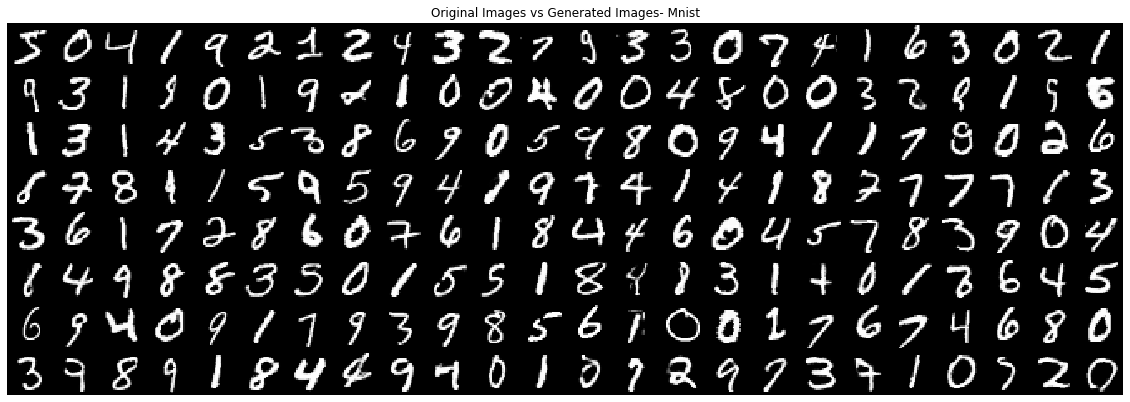

In [58]:
""" S th row represents the images from the dataset.  S = 1,3,5,7....  S%2 = 1
 (S+1)th row represents the generated images by the trained Generator Network. Clearly the Generated Network has converged.
 The images are virtually indistinguishable. I have trained the network for 40000 iterations.
"""
latent_vec = np.random.uniform(-1.0,1.0,size = [96,latent_dim])  # Sampling data from the latent space.
gen_images = Gen_Net.predict(latent_vec)  # Trained Genarator Network generating images.
rows, cols = 4, 24
num = rows*cols
imgs = np.concatenate([S_train[:num],gen_images[:num]])
imgs = imgs.reshape((rows*2, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs,rows,axis = 1))
imgs = imgs.reshape((rows*2,-1,image_size,image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs*255).astype(np.uint8)
plt.figure(figsize= (20,12))
plt.axis('off')
plt.title('Original Images vs Generated Images- Mnist')
plt.imshow(imgs, interpolation ='none', cmap = 'gray')
plt.show()